In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)
            
def gauss(x,sigma_squared,mu): return 1/np.sqrt(2*np.pi*sigma_squared)*np.exp(-(x-mu)**2/(2*sigma_squared))

def fitparallel(x,Dfit,mu):
    sigma_omega_squared = 2*Dfit*mindelay/(R*1e6)**2
    sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
    v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
    sigma_parallel_squared = (1-sigma_yomega_squared)*v_omega**2*mindelay**2-np.exp(-sigma_omega_squared)*v_omega**2*mindelay**2+2*Dfit*mindelay
    return gauss(x,sigma_parallel_squared,mu)

def fitperpendicular(x,Dfit,mu):
    sigma_omega_squared = 2*Dfit*mindelay/(R*1e6)**2
    sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
    v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
    sigma_perpendicular_squared = sigma_yomega_squared*v_omega**2*mindelay**2+2*Dfit*mindelay
    return gauss(x,sigma_perpendicular_squared,mu)

In [8]:
number=19
printnum=number
folder = "/Users/alex/Documents/Measurements/200707 - Alex Test"
#folder = "./Data example"
loadvideofile = False
if loadvideofile == False:
    dt = 0.05

pxtomum=0.0533#0.0719e-6
maxpower = 0.8
steps = 13

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3
amplitude = 1
start_time = time.time()   
if number < 10:
        tdms_file = TdmsFile(folder+"/Test_00"+str(number)+"_module.tdms")
        #analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
        #print(tdms_file['Data'].channels())
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_00"+str(number)+"_module.tdms")
else:
    if number < 100:
        tdms_file = TdmsFile(folder+"/Test_0"+str(number)+"_module.tdms")
        #analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_0"+str(number)+"_module.tdms")
    else:
        tdms_file = TdmsFile(folder+"/Test_"+str(number)+"_module.tdms")
        #analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_"+str(number)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

#Xc = tdms_file.channel_data('Data','Xc')         - old version
#Yc = tdms_file.channel_data('Data','Yc')
Xc = tdms_file['Data']['Xc']
Yc = tdms_file['Data']['Yc']
velocitytheo = tdms_file['Data']['Velocity']
angletheo = tdms_file['Data']['Angle']
xolaser = tdms_file['Data']['Xh']
yolaser = tdms_file['Data']['Yh']
Nfound = tdms_file['Data']['N']
Nlaser = tdms_file['Data']['NLaser']
delaywave = tdms_file['Data']['Delays']
iterationtime = tdms_file['Data']['Iterationtime']
programtime = tdms_file['Data']['Programtime']
phase = tdms_file['Data']['Phase']
p = tdms_file.object().properties
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
boundaryradius = p['Boundary']
offset = p['Offset']
sigmavelo = p['Sigmavelo']
vmin = p['Vmin']
vmax = p['Vmax']
videosize = p['Xsize']
vfactor = vmax - vmin
firstlength = len(Nfound)
maxlength = 0
for i in range(firstlength):
    if phase[i] == 0: maxlength += 1
if loadvideofile == True:
    dt = kinetic_cycle
timewave=np.linspace(0,firstlength*dt,firstlength)
dtprogram = np.mean(programtime)*1e-3#6.3e-3
dtexphalf = flashtime/2
dtframetransfer = videosize/binning * verticalshift
dtreadout = (1032/27e6+verticalshift)*videosize/binning
mindelay = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin
delaydt = mindelay +(delay-1)*dt

print('size of the video = ',videosize)
print('length of the movie = ',firstlength)

--- 4.39 seconds ---
size of the video =  800
length of the movie =  4102


/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)


 
Trajectory length
4102


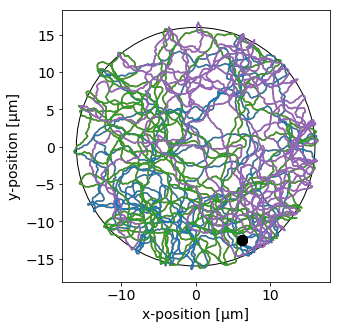

In [9]:
number = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))

particles = np.zeros((maxlength,maxnumber,6))
lastone = np.zeros((number,2))
pre = np.zeros((maxlength,maxnumber,6))
count = 0
test = np.zeros((int(Nfound[0]),2))
for i in range(int(Nfound[0])):
    test[i,0] = i
    test[i,1] = np.sqrt(pow(Xc[i]-videosize/2,2)+pow(Yc[i]-videosize/2,2))
check = sorted(test, key=lambda test: test[1])
order = np.zeros(int(Nfound[0]))
for i in range(int(Nfound[0])):
    test2 = check[i]
    order[i] = test2[0]  
for j in range(int(Nfound[0])):
    pre[0,j,0] = Xc[int(order[j])]
    pre[0,j,1] = Yc[int(order[j])]
    pre[0,j,2] = velocitytheo[int(order[j])]
    pre[0,j,3] = angletheo[int(order[j])]
    count += 1

for i in range(1,maxlength):
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,2] = velocitytheo[count]
        pre[i,j,3] = angletheo[count]
        count += 1
count = 0
for i in range(maxlength):
    for j in range(int(Nlaser[i])):  
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        
sumup = Nfound[0]
if Nfound[0] != 0: starttraj = 0
particles[0,:,:] = pre[0,:number,:]
for i in range(1,maxlength):
    if sumup != 0:
        for j in range(number):
            sumup += Nfound[i]
            if particles[i-1,j,0] != 0:
                lastone[j,0] = i-1
                lastone[j,1] = 0
            else: lastone[j,1] += 1
            xpre = particles[int(lastone[j,0]),j,0]
            ypre = particles[int(lastone[j,0]),j,1]
            mindist = 50; minnum = 666
            for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                if dist < mindist:
                    mindist = dist
                    minnum = k
                    #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
            if minnum != 666: particles[i,j,:] = pre[i,minnum,:]
    else:
        if Nfound[i] != 0:
            starttraj = i
            sumup += Nfound[i]
            for j in range(int(Nfound[i])): particles[i,j,:] = pre[i,j,:]
    #print('i = ',i,' - Nfound = ',Nfound[i],' - x[i,0] = ',int(particles[i,0,0]))
                
for i in range(1,maxlength):
    for j in range(number):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan     
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
particles[:,:,4:7] = (particles[:,:,4:6]-videosize/2)*pxtomum
save = particles.copy()
cutlastpoints = False
trajlength = np.zeros(number)
for j in range(number):
    lastfound = 0; out = True
    for i in range(starttraj+1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                        #print('j = ',j,' - i = ',i,' - gap = ',count)
                        check = False
                    else: 
                        count +=1
                        #print('i = ',i,' count =',count)
                    if count == 100:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                if out == True:
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                        particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                        particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                    #print('AFTER')
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    #print('----------')
            if i == firstlength-1: 
                trajlength[j] = i
particlessave = particles.copy()
if starttraj != 0:
    maxlength = int(maxlength-starttraj)
    particles = np.zeros((maxlength,number,6))
    particles = particlessave[starttraj:,:,:]
if cutlastpoints == True:
    particlessave = particles.copy()
    delete = firstlength - trajlength[0]
    maxlength = int(maxlength-delete)
    particles = np.zeros((maxlength,number,6))
    particles = particlessave[:maxlength,:,:]
timewave=np.linspace(0,maxlength*dt,maxlength)

print(' ')
print('Trajectory length')                  
print(maxlength)


fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(number):
    ax.scatter(particles[starttraj,0,0],particles[starttraj,0,1],color='k',s = 100,zorder=3)
    ax.plot(particles[:,i,0],particles[:,i,1],zorder=2)
    ax.plot(save[:,i,0],save[:,i,1],zorder=1)
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
plt.show()

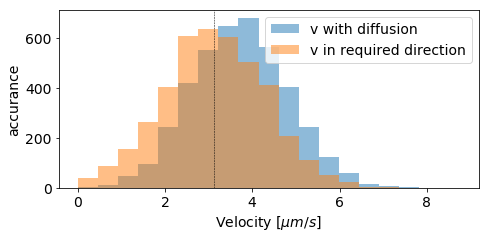

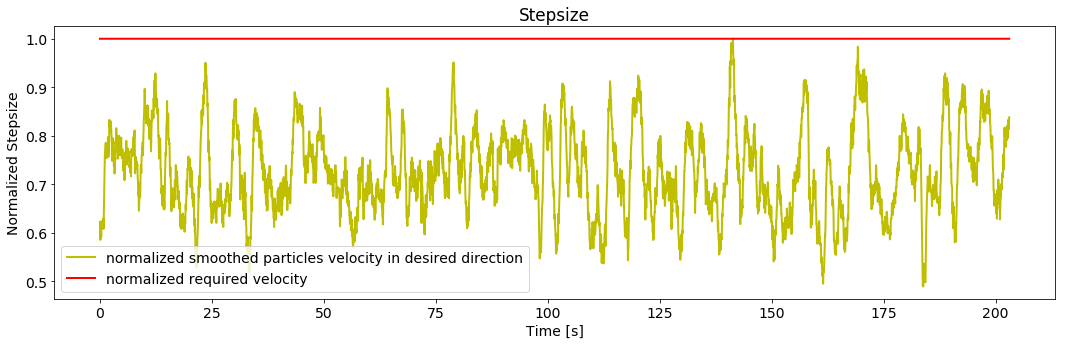

single particle =  3.133  +-  1.337  µm/s   max velocity =  7.47   µm/s
mean distance to the center =  10.74  µm


In [10]:
    savefolder ='.'
    driftdelay = 1
    particlesdisplay = np.zeros((maxlength,1,5))
    particlesdisplay[:,0,0] = particles[:,0,0];particlesdisplay[:,0,1] = particles[:,0,1]
    distancetocenter=[]                                    #Calc velocity 
    distancetocenter=np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    directionvector = np.zeros((maxlength,2))
    movingvector = np.zeros((maxlength,2))
    velocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)
    velocitywithdiffusion=np.zeros(maxlength)
    directionvector[:,0] = np.cos(particles[:,0,3]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,0,3]*np.pi/180)
    for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
        movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
        stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
        velocity[i] = stepsize[i]/dt
    velocitywithdiffusion[:maxlength] = np.sqrt(pow(movingvector[:maxlength,0],2)+pow(movingvector[:maxlength,1],2))/dt 
    binwave=np.linspace(min(velocity),min(max(velocitywithdiffusion),10),20)
    meanvelocity = np.mean(velocity)
    
    fig=plt.figure(1, figsize = (7,3.5) )
    plt.subplot(1,1,1)
    plt.hist(velocitywithdiffusion, bins=binwave,alpha = 0.5,label='v with diffusion')
    plt.hist(velocity, bins=binwave,alpha = 0.5,label='v in required direction')
    plt.axvline(x=meanvelocity,linewidth=0.5, color = 'k',linestyle='--')
    plt.xlabel('Velocity [$\mu m/s$]')
    plt.ylabel('accurance')
    plt.legend()
    plt.tight_layout() 
    plt.savefig('Histogram Stepsize'+str(printnum)+'.pdf', format='pdf')
    plt.show() 

    fig=plt.figure(1, figsize = (15,5) )
    plt.title('Stepsize')
    plt.xlabel('Time [s]')
    plt.ylabel('Normalized Stepsize')
    smoothvalue = 20
    smoothit = smooth(velocity,smoothvalue)
    xsmooth=np.linspace(0,dt*maxlength-2*smoothvalue*dt,maxlength-2*smoothvalue,endpoint=False)
    plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/max(smoothit), 'y-', lw=2,label='normalized smoothed particles velocity in desired direction')
    plt.plot(xsmooth,particles[smoothvalue:maxlength-smoothvalue,0,2], 'r-', lw=2,label='normalized required velocity')
    plt.legend()
    plt.tight_layout() 
    plt.savefig('Stepsize vs time'+str(printnum)+'.pdf', format='pdf')
    plt.show()

    np.savetxt('Datavelo'+str(printnum)+'.txt', np.transpose([velocity,smoothit,particles[:,0,2]]),fmt='%1.6f')
    print('single particle = ',round(np.mean(velocity),3),' +- ',round(np.var(velocity),3),' µm/s   max velocity = ',round(max(velocity),3),'  µm/s')
    print('mean distance to the center = ',round(np.mean(distancetocenter),2),' µm')

In [11]:
oldstartpoint = []; oldendpoint =[]
if distancetocenter[0] < boundaryradius*pxtomum:
    oldstartpoint.append(0)
    check = 0
else: check = 1; remi = -1   
count = 0
for i in range(1,maxlength):
    if distancetocenter[i] > boundaryradius*pxtomum:
        if check == 0:
            remi = i
            check = 1
        count += 1
    if check == 1: 
        if distancetocenter[i] < boundaryradius*pxtomum:
            check = 0
            if remi != -1:
                oldstartpoint.append(i)
                oldendpoint.append(remi)
            else: oldstartpoint.append(i)
        else: count += 1   
if check == 1: oldendpoint.append(remi)
else: oldendpoint.append(maxlength-1)
    
newangle = np.zeros(maxlength); newangle = particles[:,0,3].copy()
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
 
delaydirection = 2    #in frames
moveangle = np.zeros(maxlength);diffmoveangle = np.zeros(maxlength)
for i in range(1,maxlength):
    dx = particles[i,0,0]-particles[i-1,0,0]      #Calc moving direction
    dy = particles[i,0,1]-particles[i-1,0,1]
    moveangle[i] = np.arctan(dy/dx)*180/np.pi
    if moveangle[i] != moveangle[i]: moveangle[i] = 90
    if dx > 0:
        if dy < 0: moveangle[i] += 360
    else: moveangle[i] += 180
    if moveangle[i]>360: moveangle[i] -= 360
    if moveangle[i]<0: moveangle[i] += 360
    if i >= delaydirection:                       #Calc angle difference between required direction and real direction
        diffmoveangle[i] = particles[i-delaydirection,0,3] - moveangle[i]
        if abs(diffmoveangle[i]) > 180:
            if diffmoveangle[i] > 0: diffmoveangle[i] -= 360
            else: diffmoveangle[i] += 360
moveangle[0] = moveangle[1]
            
newmoveangle = np.zeros(maxlength); newmoveangle = moveangle.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newmoveangle[i]-newmoveangle[i-1])
    diff[1] = abs(newmoveangle[i]-newmoveangle[i-1]+360)
    diff[2] = abs(newmoveangle[i]-newmoveangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newmoveangle[i:] += 360
        else: newmoveangle[i:] -= 360
            
iwave = [];pathwave = []; startpoint = []; endpoints = []
count = 0; value = 0.9; check = 1; countpoint = 0; countlength=0; countlengthmax=0; remend=0
for i in range(maxlength):
    if i>oldstartpoint[countpoint] and i<oldendpoint[countpoint]:
        if particles[i,0,2] > value:
            if check == 1:
                startpoint.append(i)
                if remend != 0: endpoints.append(remend)                               
            check = 0
            iwave.append(i)
            pathwave.append(count)
            countlength += 1
            remend = i
        else: 
            if check == 0:
                check = 1
                count += 1
                if countlength > countlengthmax: countmaxlength = countlength
                countlength = 0
    else:
        if countpoint+1 < len(oldstartpoint):
            if i>oldstartpoint[countpoint+1]:
                check = 1
                countpoint += 1
                count +=1
                if countlength > countlengthmax: countmaxlength = countlength
                countlength = 0
                i -= 1
if len(endpoints) != 0: 
    if endpoints[-1] != remend: endpoints.append(remend)
else: endpoints.append(shortlength)

/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: Degrees of freedom <= 0 for slice.


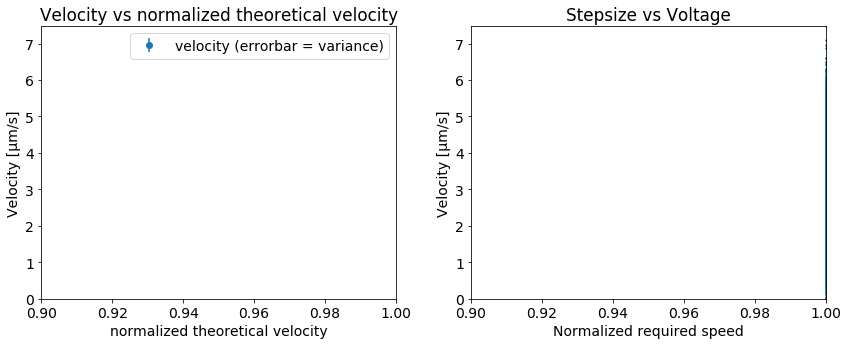

voltage =  [1. 1. 1. 1. 1. 1.]
speed =    [nan nan nan nan nan nan]
counts =   [0. 0. 0. 0. 0. 0.]
max velocity =  nan


In [12]:
value = particles[:,0,2]
steps2 = 6
speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
speedcollect=np.zeros((steps2,maxlength))
for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
    if value[i] < speedhisto[0,0]:
        speedhisto[0,1] += velocity[i]
        speedcollect[0,int(speedhisto[0,2])] = velocity[i]
        speedhisto[0,2] += 1
    else:
        for j in range(1,steps2):
            if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                speedhisto[j,1] += velocity[i]
                speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                speedhisto[j,2] += 1
speedhisto[:,1] /= speedhisto[:,2]
for i in range(maxlength):
    for j in range(steps2):
        if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan
valueprint = np.zeros(steps2);veloprint = np.zeros(steps2); plotvaluehisto = np.zeros(steps2)
for i in range(steps2):                          #Convert into a printable value
    valueprint[i] = round(speedhisto[i,0],2)
    veloprint[i] = round(speedhisto[i,1],2)
    plotvaluehisto[i] = round(speedhisto[i,0]-(1-min(value))/(2*steps2),2)
    speedhisto[i,3] = nanvar(speedcollect[i,:])  
data = []
for i in range(steps2): data.append(speedcollect[i,:int(speedhisto[i,2])])
    
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
ax = plt.subplot(1, 2, 1)
plt.errorbar(plotvaluehisto[:], speedhisto[:,1],yerr=speedhisto[:,3], fmt='o',label='velocity (errorbar = variance)') #(errorbar = variance/sqrt(N))
plt.title('Velocity vs normalized theoretical velocity')
plt.xlabel('normalized theoretical velocity')
plt.ylabel('Velocity [µm/s]')
plt.ylim([0,min(max(velocity),10)])
plt.xlim([0.9*min(value),1])
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.title('Stepsize vs Voltage')
plt.xlabel('Normalized required speed')
plt.ylabel('Velocity [µm/s]')
plt.scatter(value,velocity, s=2)
plt.ylim([0,min(max(velocity),10)])
plt.xlim([0.9*min(value),1])
plt.tight_layout() 
plt.savefig('Velocity vs Normalized required speed'+str(printnum)+'.pdf', format='pdf')
plt.show()
    
print('voltage = ',valueprint)
print('speed =   ',veloprint)
print('counts =  ',speedhisto[:,2])
maxvelocity = round(speedhisto[-1,1],2)
print('max velocity = ',maxvelocity)

THEORY
D_0 =  0.207  µm^2/s
sigma_parallel =  nan
sigma_perpendicular =  nan
----------------
FROM PARALLEL
fit D_0 =  0.207  +-  inf µm^2/s
fit sigma_parallel =  nan  +-  inf  µm
----------------
FROM PERPENDICULAR
fit D_0 =  0.207  +-  inf µm^2/s
fit sigma_perpendicular =  nan  +-  inf  µm


/Users/alex/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


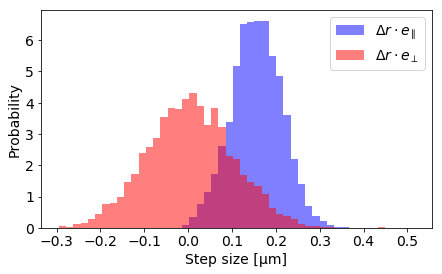

In [13]:
fastlength = 0
for i in range(len(startpoint)): fastlength += endpoints[i]-startpoint[i]
stepsparallel = np.zeros(fastlength); stepsperpendicular = np.zeros(fastlength)
count = 0
testwave = np.zeros(maxlength)
for i in range(len(startpoint)):
    herelength = endpoints[i]-startpoint[i]
    stepsparallel[count:count+herelength] = stepsize[startpoint[i]:endpoints[i]] 
    count2 = 0
    for j in range(startpoint[i],endpoints[i]):
        a = directionvector[j-2,:]; b = movingvector[j,:]
        test = np.math.atan2(np.linalg.det([a,b]),np.dot(a,b))
        testwave[count+count2] = test
        stepsperpendicular[count+count2] = np.sqrt(pow(velocitywithdiffusion[j]*dt,2)-pow(stepsize[j],2))
        if test < 0: stepsperpendicular[count+count2] *= -1
        count2 += 1        
    count += herelength
meanstepparallel = np.mean(stepsparallel)

binnumber = 25
binnumber2 = 50
binsall = np.linspace(min(stepsparallel+stepsperpendicular),max(stepsparallel+stepsperpendicular),binnumber2)
binsparallel = np.linspace(min(stepsparallel),max(stepsparallel),binnumber)
binsparallel2 = np.linspace(min(stepsparallel),max(stepsparallel),10*binnumber)
binsperpendicular = np.linspace(min(stepsperpendicular),max(stepsperpendicular),binnumber)
binsperpendicular2 = np.linspace(min(stepsperpendicular),max(stepsperpendicular),10*binnumber)
binsparallelcenter = np.zeros(binnumber-1); binsperpendicularcenter = np.zeros(binnumber-1)
for i in range(binnumber-1):
    binsparallelcenter[i] = (binsparallel[i]+binsparallel[i+1])/2
    binsperpendicularcenter[i] = (binsperpendicular[i]+binsperpendicular[i+1])/2

D_0 = kB*T/(6*np.pi*eta*R)
sigma_omega_squared = 2*D_0*1e12*mindelay/(R*1e6)**2
sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
sigma_parallel_squared = (1-sigma_yomega_squared)*v_omega**2*mindelay**2-np.exp(-sigma_omega_squared)*v_omega**2*mindelay**2+2*D_0*1e12*mindelay
sigma_perpendicular_squared = sigma_yomega_squared*v_omega**2*mindelay**2+2*(D_0*1e12)*mindelay
print('THEORY')
print('D_0 = ',round(D_0*1e12,3),' µm^2/s')
print('sigma_parallel = ',round(sigma_parallel_squared,4))
print('sigma_perpendicular = ',round(sigma_perpendicular_squared,4))
print('----------------')    
    
fig=plt.figure(1, figsize = (7,4) )
ax = plt.subplot(1,1,1)
histoparallel = np.histogram(stepsparallel,bins=binsparallel,density=1)
popt,pcov = curve_fit(fitparallel, binsparallelcenter, histoparallel[0],p0 = (D_0*1e12,meanstepparallel))
pErr = np.sqrt(np.diag(pcov))
plt.plot(binsparallel2,fitparallel(binsparallel2,*popt),linestyle='--',c='b',linewidth=1.5)
histoall = plt.hist(stepsparallel,bins=binsall,density=1,color='b',alpha=0.5,label=r'$\Delta r \cdot e_{\parallel }$')
D_0_parallel = popt[0]; D_0_parallel_err = pErr[0]
print('FROM PARALLEL')
print('fit D_0 = ',round(D_0_parallel,3),' +- ',round(D_0_parallel_err,3),'µm^2/s')
#plt.scatter(binsparallelcenter, histoparallel[0])
popt,pcov = curve_fit(gauss, binsparallelcenter, histoparallel[0],p0 = (sigma_parallel_squared,meanstepparallel))
pErr = np.sqrt(np.diag(pcov))
sigma_parallel_fit = popt[0]; sigma_parallel_fit_err = pErr[0]
#plt.plot(binsparallelcenter,gauss2(binsparallelcenter,*popt),linestyle='--',c='k',linewidth=1.5)
print('fit sigma_parallel = ',round(sigma_parallel_fit,4),' +- ',round(sigma_parallel_fit_err,4),' µm')
print('----------------')

histoperpendicular = np.histogram(stepsperpendicular,bins=binsperpendicular,density=1)
popt,pcov = curve_fit(fitperpendicular, binsperpendicularcenter, histoperpendicular[0],p0 = (D_0_parallel,0))
pErr = np.sqrt(np.diag(pcov))
plt.plot(binsperpendicular2,fitperpendicular(binsperpendicular2,*popt),linestyle='--',c='r',linewidth=1.5)
histoall = plt.hist(stepsperpendicular,bins=binsall,density=1,color='r',alpha=0.5,label=r'$\Delta r \cdot e_{\perp  }$')
D_0_perpendicular = popt[0]; D_0_perpendicular_err = pErr[0]
print('FROM PERPENDICULAR')
print('fit D_0 = ',round(D_0_perpendicular,3),' +- ',round(D_0_perpendicular_err,3),'µm^2/s')
popt,pcov = curve_fit(gauss, binsperpendicularcenter, histoperpendicular[0],p0 = (sigma_perpendicular_squared,0))
pErr = np.sqrt(np.diag(pcov))
sigma_perpendicular_fit = popt[0]; sigma_perpendicular_fit_err = pErr[0]
print('fit sigma_perpendicular = ',round(sigma_perpendicular_fit,4),' +- ',round(sigma_perpendicular_fit_err,4),' µm')

plt.xlabel('Step size [µm]')
plt.ylabel('Probability')
plt.legend()
plt.savefig('Stepdistribution.pdf', format='pdf')
plt.show()